# Introduction 
This notebook demonstrates the Metropolis-Hastings Markov Chain Monte Carlo (MH-MCMC) process applied to partial orders, implementing the methodology described in [Nicholls et al. (2024)](https://arxiv.org/abs/2212.05524).

The notebook covers two main aspects:

a) Generation and sampling:
- Generate a target partial order from latent positions
- Sample total orders that respect the target partial order
- Visualize the generated partial order and sampled total orders

b) Inference:
- Use the sampled total orders to infer the original partial order
- Implement MCMC sampling with proper proposal distributions
- Analyze convergence and posterior distributions

The configuration for the MCMC process is loaded from `mcmc_config.yaml`, which specifies:
- Sampling parameters (iterations, burn-in)
- Model parameters (priors, proposal distributions)
- Visualization settings

## Mathematical Background

The methodology is based on a Hidden Markov Model where:
- The hidden state represents an evolving partial ordered set (poset)
- The emitted data are random total orders respecting the poset
- The model accounts for noise through a random "queue-jumping" process
### Partial Order Model Theorem:


For α and Σρ defined above, if we take:

<div style="text-align: center">

Uj,: ∼ N(0, Σρ), independent for each j ∈ M

ηj,: = G⁻¹(Φ(Uj,:)) + αj 1ᵀₖ

y ∼ p(·|h(η(U, β)))

</div>

then h(η:,k) ∼ PL(α; M) for each k = 1, ..., K. In particular, if K = 1 then y ∼ PL(α; M).

This theorem establishes the theoretical foundation for our partial order model, where:
- U represents the latent variables following a multivariate normal distribution with N*K dimensions
- η represents the transformed latent variables
- h(η) generates the partial order structure
- PL(α; M) denotes the Plackett-Luce distribution with parameters α and M


# Coding
## Importing the necessary libraries and functions 

In [18]:
import sys
import os
import yaml
import numpy as np
import networkx as nx
import random
import itertools
import matplotlib.pyplot as plt
import pygraphviz as pgv
from typing import List, Dict, Any
import seaborn as sns
from scipy.stats import beta

# Add the parent directory to the system path to enable importing of custom modules
project_root = os.path.dirname(os.getcwd())  # Moves up one directory level from the notebook's location
sys.path.append(project_root)

# Import custom modules
from src.utils.basic_utils import BasicUtils
from src.utils.statistical_utils import StatisticalUtils
from src.utils.generation_utils import GenerationUtils
from src.visualization.po_plot import POPlot
from src.mcmc.likelihood_cache import LogLikelihoodCache
from src.mcmc.mcmc_simulation import mcmc_partial_order

# Load configuration
# Assuming the mcmc_config.yaml is located in the parent directory of the notebook directory
config_path = os.path.join(project_root, "config/mcmc_config.yaml")

with open(config_path, "r") as f:
    config = yaml.safe_load(f)



## Generate the partial order h given the prior parameters of rho 
### Generating a Partial Order
We generate a partial order using the `generate_random_PO` function and provide the basic description of the PO.
#### Comments on Generating Samples from a Given Partial Order:

- **Setting the Parameter `N`:**
  - The value of `N` should be chosen thoughtfully to ensure the quality of the MCMC sampling.


In [19]:
# 1. Set up parameters for partial order generation
n = 6  # Number of nodes/items in the partial order
N = 30  # Number of total orders to sample from the partial order

# 2. Load configuration parameters
K = config["mcmc"]["K"]  # Number of dimensions for latent positions
rho_prior = config["prior"]["rho_prior"]  # Prior parameter for correlation
noise_option = config["noise"]["noise_option"]  # Noise model specification
mallow_ua = config["prior"]["mallow_ua"]  # Mallows model parameter


items = list(range(n))  # Create list of item indices to represent the items 

# 3. Generate true correlation parameter from prior
rho_true = beta.rvs(1, rho_prior)  # Sample from Beta(1, rho_prior) distribution
print(f"True correlation parameter (rho): {rho_true:.4f}")

# 4. Set up covariates and regression parameters
# X: M × p design matrix (p is number of covariates)
# β: p × 1 vector of regression coefficients
p = config["covariates"]["p"]  # Number of covariates
beta_true = config["covariates"]["beta_true"]   # True regression coefficients
X = np.random.randn(p, n) 
 # Example design matrix
# 5. Compute assessor-specific effects
# α = Xβ is an M × 1 vector of assessor effects
alpha = X.T @ beta_true  
print("\n The covariates effects (alpha):")
print(alpha)



True correlation parameter (rho): 0.9159

 The covariates effects (alpha):
[-0.2789459   0.72824901 -0.02170579  0.84452989 -0.02157357  1.16254806]



Base U matrix (latent positions):
[[-2.4263466  -1.73808242 -1.97791024]
 [-1.21385009 -0.92442498 -1.14330345]
 [ 0.26729329 -0.01168753  0.34052873]
 [-0.98446096 -0.9983891  -0.51973162]
 [-0.43594853 -0.20379461 -0.0276268 ]
 [ 0.29417202  0.05776233  0.16972118]]

Adjusted latent positions (eta):
[[-1.86331453e+00 -1.43952850e+00 -1.59561592e+00]
 [-5.36730496e-02  1.81262226e-01  1.73552924e-03]
 [ 6.67645233e-01  3.31381291e-01  7.61678765e-01]
 [ 2.47112461e-01  2.35544061e-01  6.63400976e-01]
 [-1.20800988e-01  1.18526585e-01  3.13292516e-01]
 [ 1.88611953e+00  1.59623598e+00  1.73044384e+00]]

Regression Information:
Design Matrix (X):
[[-0.4278123   1.57309985  0.6850237   0.75047738 -0.80200659  1.61778603]
 [ 0.21679918  0.19433639  1.21405879 -1.56430401 -1.26476576 -1.17885015]]

True Regression Coefficients (beta):
[0.5, -0.3]

CovariatesEffects (alpha = Xβ):
[-0.2789459   0.72824901 -0.02170579  0.84452989 -0.02157357  1.16254806]

Partial Order (adjacency matrix):
[[

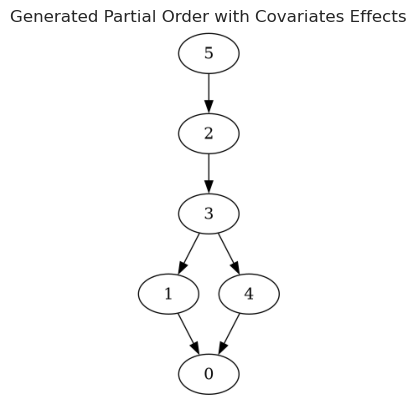

In [20]:

# 6. Generate latent positions for each assessor
# U matrix represents the base latent positions in K-dimensional space
U = GenerationUtils.generate_U(n, K, rho_true)
print("\nBase U matrix (latent positions):")
print(U)

# 7. Generate latent positions with covariates effects
# η = U + α1ᵀₖ (adding covariates effects)
eta = StatisticalUtils.transform_U_to_eta(U, alpha)
print("\nAdjusted latent positions (eta):")
print(eta)

print("\nRegression Information:")
print("Design Matrix (X):")
print(X)
print("\nTrue Regression Coefficients (beta):")
print(beta_true)
print("\nCovariatesEffects (alpha = Xβ):")
print(alpha)

# 8. Generate partial order from adjusted latent positions
# First generate the full partial order
h = BasicUtils.generate_partial_order(eta)
# Then compute its transitive reduction to remove redundant edges
h_true = BasicUtils.transitive_reduction(h.copy())
print("\nPartial Order (adjacency matrix):")
print(h_true)

# 9. Print descriptive statistics of the generated partial order
print("\nPartial Order Statistics:")
print(f"Number of items: {n}")
print(f"Number of covariates: {p}")
print(f"Number of direct relationships: {np.sum(h_true)}")
print(f"Number of linear extensions: {BasicUtils.nle(h_true)}")

# 10. Visualize the partial order
POPlot.visualize_partial_order(
    h_true, 
    items,
    title='Generated Partial Order with Covariates Effects'
)


## B) Generate Total Orders with Queue Jump Error

This section demonstrates how to generate total orders from the given partial order while incorporating queue jump errors. The process involves:

1. **Subset Sampling**
   - Given a partial order, sample a subset of items
   - This subset contains the selected items for each ordre 

2. **Queue Jump Error Model**
   - Items are selected from the top of a queue
   - The queue continues to mix rapidly
   - Selection is constrained by the suborder on remaining items
    Before the iᵗʰ entry (yᵢ) is chosen:
    - There are m - i + 1 elements remaining (yᵢ:m)
    - With probability p: yᵢ is chosen randomly (ignoring order constraints)
    - With probability (1-p): yᵢ is the maximal element in a random linear extension

The probability of a sequence y₁:m given poset h and noise parameter p is:

<div style="text-align: center">

pₛ(y₁:m|h, p) = ∏ᵢ₌₁ᵐ⁻¹ q(yᵢ:m|h[yᵢ:m], p)

</div>

where:

<div style="text-align: center">

q(yᵢ:m|h[yᵢ:m], p) = p/(m-j+1) + (1-p)qᵧᵢₘ(yᵢ|h[yᵢ:m])

</div>


In [21]:
## Generate the subsets 
items = list(range(n))
item_to_index = {item: idx for idx, item in enumerate(items)}

subsets = GenerationUtils.generate_subsets(N, n)
print(subsets)
## we generate the queue jump noise total order for each subset


[[0, 1, 3], [0, 1, 5], [0, 1, 2, 4, 5], [0, 4], [0, 1, 2, 3, 5], [2, 3, 5], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 5], [2, 3, 4], [0, 1, 3, 4, 5], [0, 1, 2, 3, 4, 5], [0, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5], [4, 5], [1, 2], [0, 1, 2, 3, 4, 5], [1, 2, 3, 4, 5], [0, 1, 3, 4, 5], [2, 3, 4, 5], [1, 2, 5], [0, 1, 2, 4, 5], [0, 1, 2, 3, 4, 5], [1, 2, 3, 5], [0, 1, 2, 3, 5], [0, 1, 3, 4, 5], [0, 1, 2, 3, 4, 5], [0, 1, 4], [2, 3, 4, 5], [0, 3, 4], [0, 2, 4, 5]]


In [22]:
## Genearte the total order 
h_tc=BasicUtils.transitive_closure(h)
noise_beta_prior = config["prior"]["noise_beta_prior"] 
prob_noise = StatisticalUtils.rPprior(noise_beta_prior)
prob_noise_true=prob_noise

total_orders = []
for choice_set in subsets:
    if noise_option == "queue_jump":
        y_generated = StatisticalUtils.generate_total_order_for_choice_set_with_queue_jump(choice_set, items,h_tc, prob_noise)

    elif noise_option == "mallows_noise":
        y_generated = StatisticalUtils.generate_total_order_for_choice_set_with_mallow_noise(choice_set,items, h_tc,  mallow_ua)
    total_orders.append(y_generated)

# Analyze the order distribution
print("\nSampling Statistics:")
print(f"Number of unique total orders: {len(set(map(tuple, total_orders)))}")
print(f"Most common ordering: {max(set(map(tuple, total_orders)), key=total_orders.count)}")



Sampling Statistics:
Number of unique total orders: 21
Most common ordering: (4, 0)


## B) MCMC Simulation for Partial Order Inference

This section implements the Metropolis-Hastings MCMC algorithm to infer the underlying partial order h from observed total orders. We'll analyze both the convergence of the chain and the posterior distribution of the inferred partial order.

### Implementation

In [23]:
num_iterations = config["mcmc"]["num_iterations"]
K = config["mcmc"]["K"]
mcmc_pt = [
    config["mcmc"]["update_probabilities"]["rho"],
    config["mcmc"]["update_probabilities"]["noise"],
    config["mcmc"]["update_probabilities"]["U"]
]
dr = config["rho"]["dr"]

noise_option = config["noise"]["noise_option"]
sigma_mallow = config["noise"]["sigma_mallow"]

noise_beta_prior = config["prior"]["noise_beta_prior"]
mallow_ua = config["prior"]["mallow_ua"]
alpha = X.T @ beta_true  

 
mcmc_results = mcmc_partial_order(
    total_orders,
    subsets,
    num_iterations,
    K,
    dr,
    sigma_mallow,
    noise_option,
    mcmc_pt,
    rho_prior, 
    noise_beta_prior,
    mallow_ua,
    alpha 
)

print("MCMC run complete. Returned keys:")
print(mcmc_results.keys())

Iteration 40000/400000 - Accept Rate: 29.71%
Iteration 80000/400000 - Accept Rate: 29.68%
Iteration 120000/400000 - Accept Rate: 29.70%
Iteration 160000/400000 - Accept Rate: 29.48%
Iteration 200000/400000 - Accept Rate: 29.55%
Iteration 240000/400000 - Accept Rate: 29.57%
Iteration 280000/400000 - Accept Rate: 29.55%
Iteration 320000/400000 - Accept Rate: 29.56%
Iteration 360000/400000 - Accept Rate: 29.63%
Iteration 400000/400000 - Accept Rate: 29.61%

Overall Acceptance Rate after 400000 iterations: 29.61%
MCMC run complete. Returned keys:
dict_keys(['Z_trace', 'h_trace', 'index_to_item', 'item_to_index', 'rho_trace', 'prob_noise_trace', 'mallow_theta_trace', 'proposed_rho_vals', 'proposed_prob_noise_vals', 'proposed_mallow_theta_vals', 'proposed_Zs', 'acceptance_rates', 'acceptance_decisions', 'log_likelihood_currents', 'log_likelihood_primes', 'overall_acceptance_rate'])


### Plot the likelihood of the mcmc 


Excluding 100000 burn-in iterations


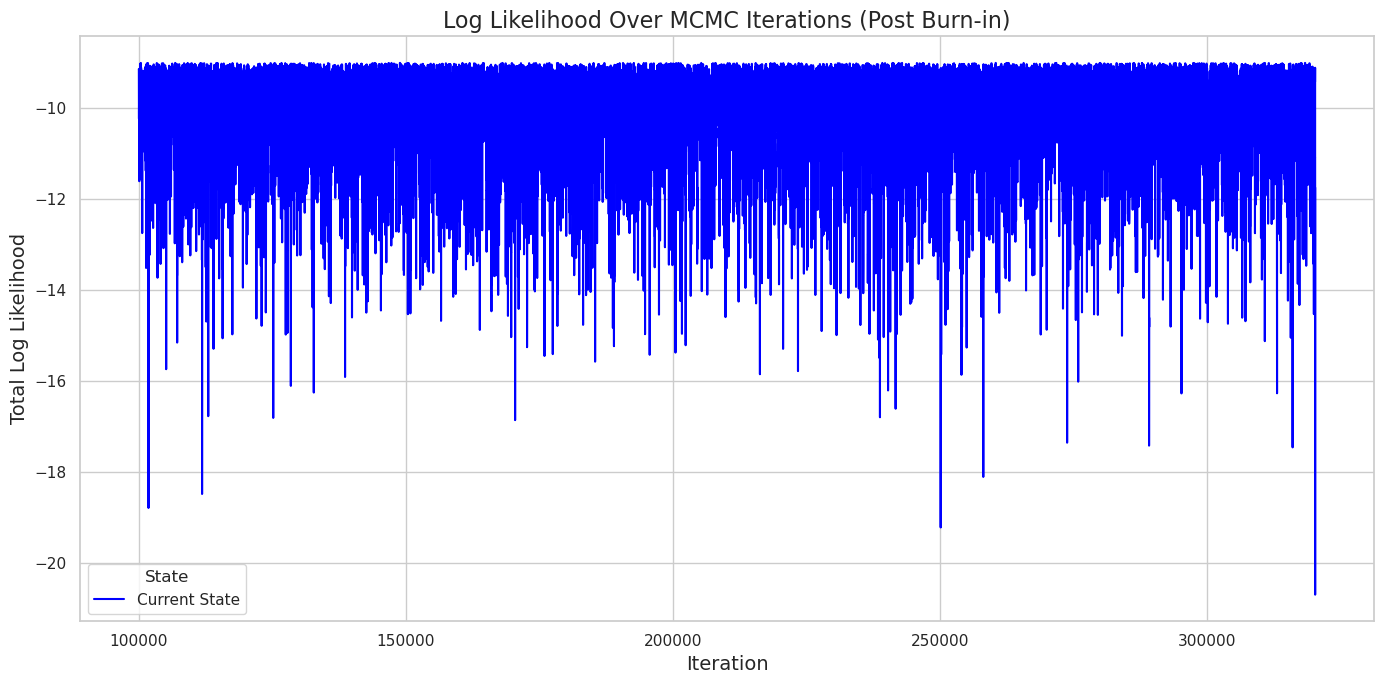

In [30]:
# Get log likelihood values from MCMC results
log_likelihood_currents = mcmc_results.get('log_likelihood_currents', [])

# Create plot
POPlot.plot_log_likelihood(log_likelihood_currents, burn_in=100000)

### The partial order result analysis: 

- Posterior mean of partial orders is computed from remaining iterations
- Threshold of 0.5 is applied to convert posterior probabilities to binary decisions

In [31]:
burn_in = int(100000/ 100)  # Convert to integer (1000 instead of 1000.0)
post_burn_in_trace=mcmc_results['h_trace'][burn_in:]
h_final=np.mean(post_burn_in_trace,axis=0)

threshold=0.5
index_to_item = mcmc_results['index_to_item']
iterations = list(range(1, num_iterations + 1))

h_final_inferred=BasicUtils.transitive_reduction(h_final>=threshold).astype(int)


print("Final adjacency (thresholded):")
print(h_final_inferred)

Final adjacency (thresholded):
[[0 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 1 0 0]
 [0 1 0 0 1 0]
 [1 0 0 0 0 0]
 [0 0 1 0 0 0]]


Visulise for the h_trace from MCMC, the functions counts the unique partial orders in the h_Trace and also show top N partial orders with counts and percentages.  

Total number of samples in h_trace: 3000



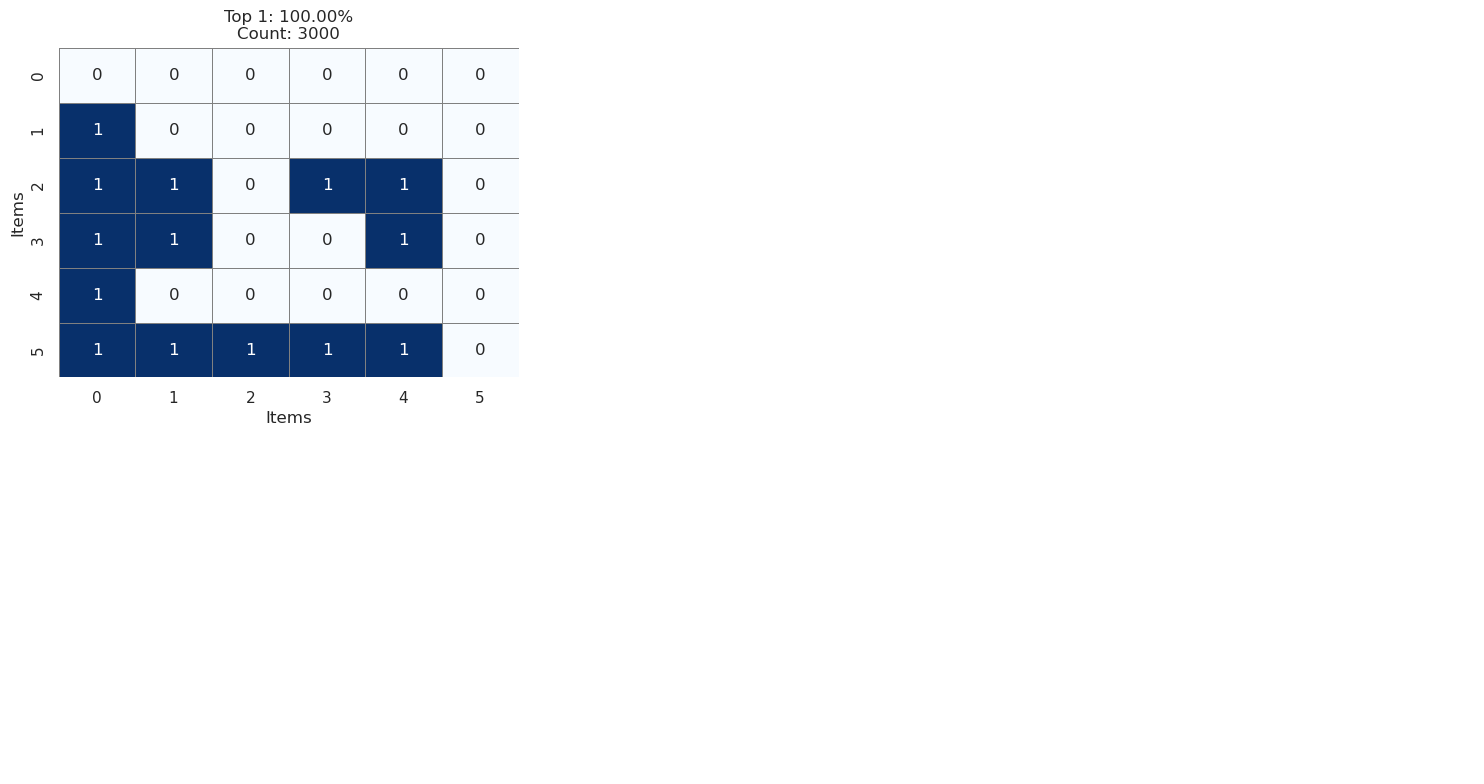

Excluding 1000 burn-in iterations


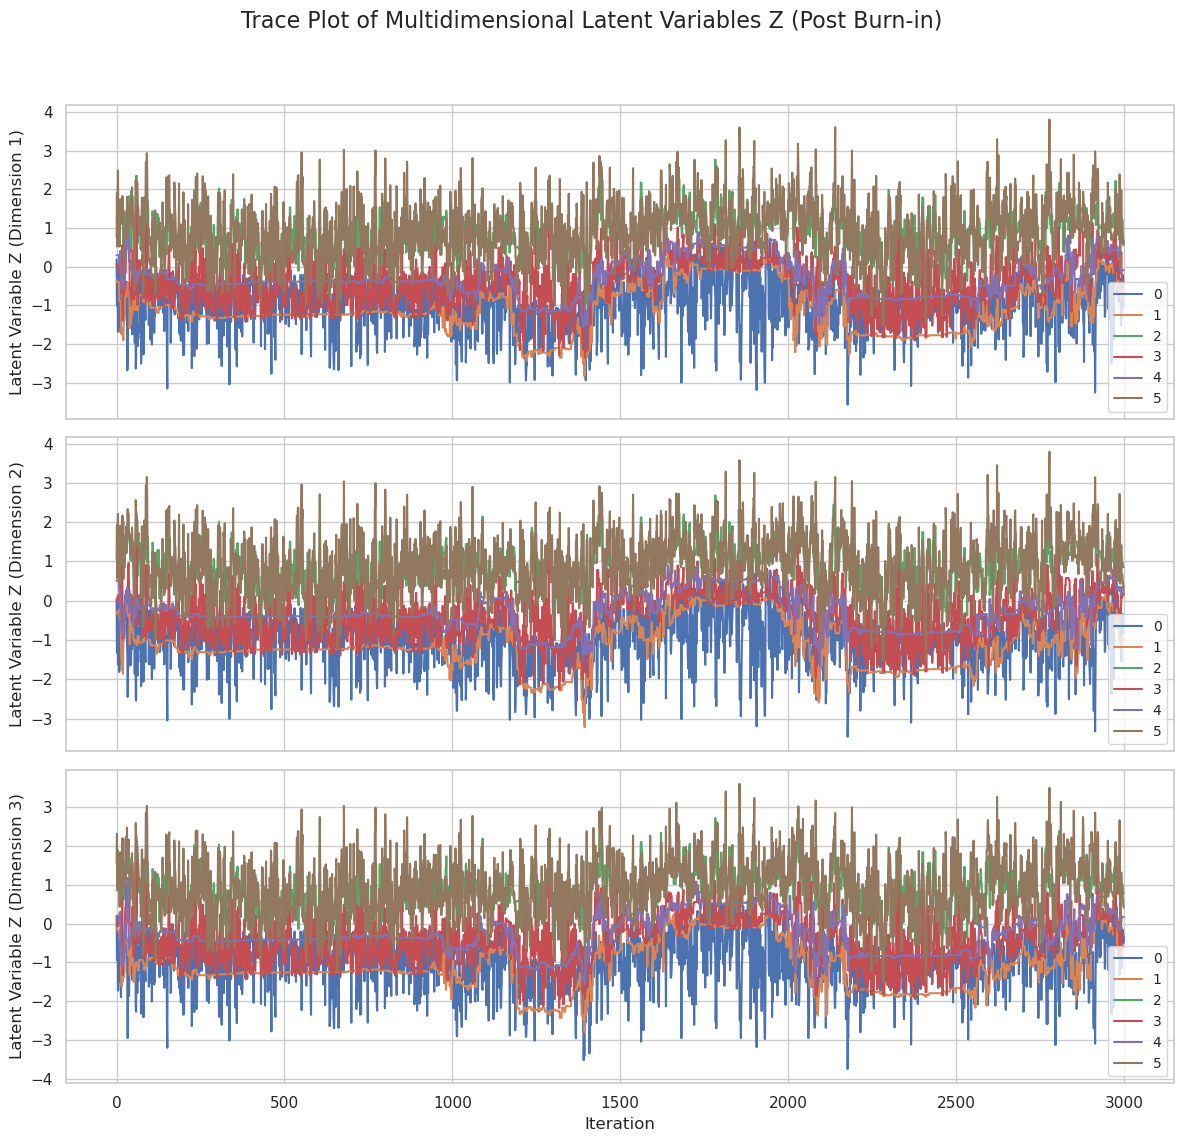

In [32]:
# Analyze partial orders from MCMC results

sorted_unique_orders = StatisticalUtils.count_unique_partial_orders(post_burn_in_trace)       

total_samples = sum(count for _, count in sorted_unique_orders)
print(f"Total number of samples in h_trace: {total_samples}\n")
top_n = 5
top_partial_orders = sorted_unique_orders[:top_n]
top_percentages = [(order, count, (count / total_samples) * 100) for order, count in top_partial_orders]

items = sorted(set(itertools.chain.from_iterable(total_orders)))
n = len(items)
item_labels = items  # ['A', 'B', 'C']
# Plot the top 5 partial orders
POPlot.plot_top_partial_orders(top_percentages, top_n=top_n, item_labels=item_labels)

POPlot.plot_Z_trace(
    mcmc_results['Z_trace'],
    index_to_item,
    burn_in=burn_in  # adjust burn-in period as needed
)

### Inferred h comparison 
In the end, we want to compare the simulated h and the true h, especially the missing relationship between items.

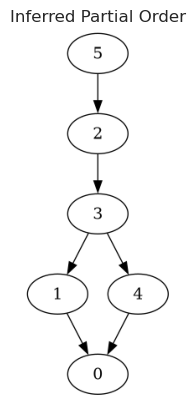

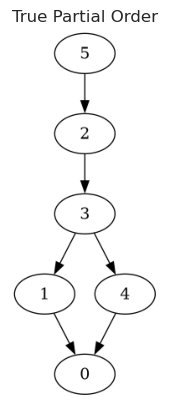


No missing relationships. The inferred partial order matches the true partial order.

No redundant relationships. The inferred partial order is a subset of the true partial order.


In [33]:

missing_relationships = BasicUtils.compute_missing_relationships(h_true, h_final_inferred, index_to_item)
redundant_relationships= BasicUtils.compute_redundant_relationships(h_true, h_final_inferred, index_to_item)

# Plot Inferred Partial Order
POPlot.visualize_partial_order(
    final_h=h_final_inferred,
    Ma_list=items, 
    title='Inferred Partial Order',
)

# Plot True Partial Order and Inferred Partial Order
POPlot.visualize_partial_order(
    final_h=BasicUtils.transitive_reduction(h_true),
    Ma_list=items, 
    title='True Partial Order',
)

if missing_relationships:
    print("\nMissing Relationships (edges present in true PO but absent in inferred PO):")
    for i, j in missing_relationships:
        print(f"{i} < {j}")
else:
    print("\nNo missing relationships. The inferred partial order matches the true partial order.")

if redundant_relationships:
    print("\nRedundant Relationships (edges present in inferred PO but absent in true PO):")
    for i, j in redundant_relationships:
        print(f"{i} < {j}")
else:
    print("\nNo redundant relationships. The inferred partial order is a subset of the true partial order.")

[INFO] Saved MCMC parameter plots to 'mcmc_inferred_result.pdf'


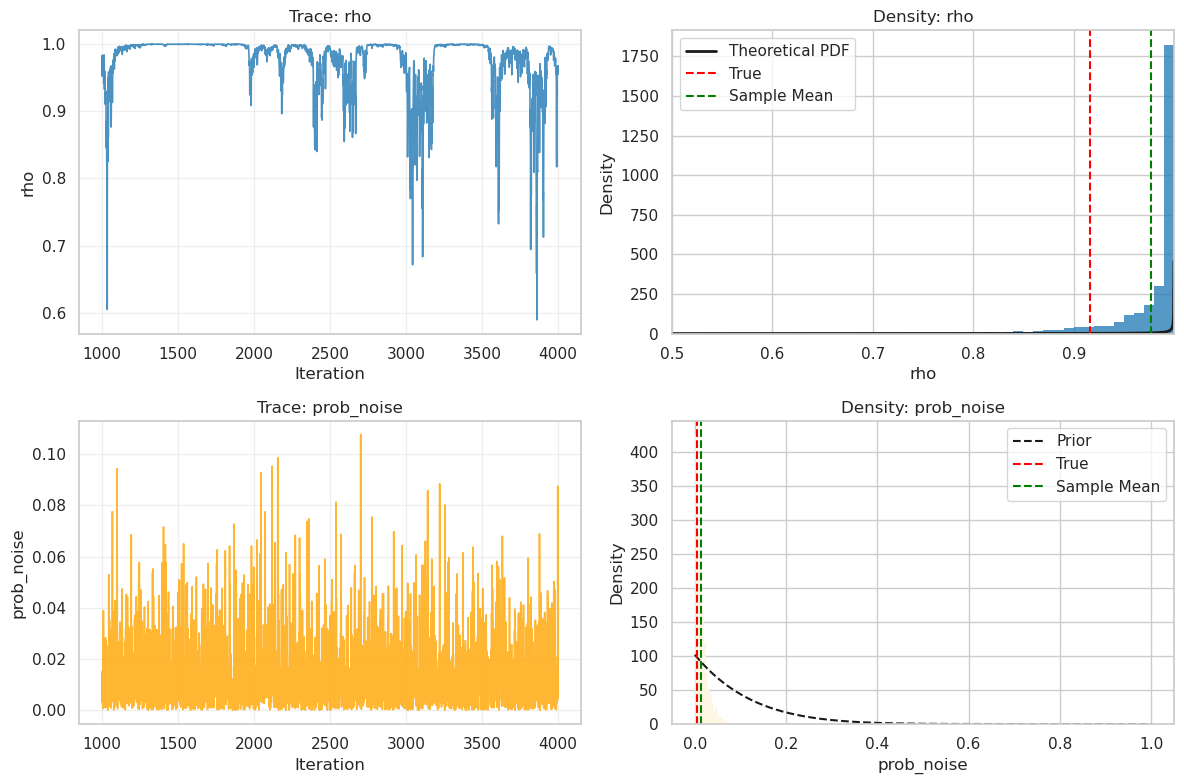

In [34]:

true_param = {
    "rho_true": rho_true,
    "prob_noise_true": prob_noise_true,

}
POPlot.plot_mcmc_inferred_variables(
    mcmc_results,
    true_param,
    config,
    burn_in=burn_in,  # optional
    output_filename="mcmc_inferred_result.pdf"
)